# Q-Trainer for VQE

In [1]:
import qtrainer
import pennylane as qml
from pennylane import numpy as qnp
import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Hamiltonian

Here, we define a simple Hamiltonian following the [Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_diffable-mitigation.html)
$$H = - \sum_i X_i X_{i+1} + 0.5 \sum_i Z_i$$

In [2]:
n_qubits = 4
coeffs = [1.0] * (n_qubits - 1) + [0.5] * n_qubits
observables = [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(n_qubits - 1)]
observables += [qml.PauliZ(i) for i in range(n_qubits)]
H = qml.Hamiltonian(coeffs, observables)

## Q-Trainer's VQE Circuit

For VQE, we need to define an ansatz with initial parameters

In [3]:
n_layers = 2
init_params = [qnp.ones((n_qubits), requires_grad=True),
               qnp.ones((n_layers, n_qubits - 1, 2), requires_grad=True)]
def ansatz(w1, w2):
    qml.SimplifiedTwoDesign(w1, w2, wires=range(n_qubits))

Now, we can construct VQE Circuit with the VQE task config (`Hamiltonian`, `n_qubits`) and the ansatz config (`ansatz`, `init_params`)

In [4]:
circuit = qtrainer.VQECircuit(Hamiltonian=H, n_qubits=n_qubits, 
                                       ansatz=ansatz, init_params=init_params)

## Noise Model
Depolarization noise on all gates

In [5]:
# noise model
noise_gate = qml.DepolarizingChannel
noise_strength = 0.05
noise_fn = qml.transforms.insert(noise_gate, noise_strength, position="all")

## Trainer
+ `circuit`: Q-Trainer Circuit class
+ `device_name`: Pennylane-stype device name. (For noised simulation, use `default.mixed`/`cirq.mixedsimulator`/`braket_dm`.)
+ `optimizer`: could be `Adam`, `SGD`, `ShotAdaptive`, `SPSA`, etc.
+ `noise_fn`: preset noise function
+ `error_mitigation_method`: Quantum error mitigation method. Currently, only Zero-Noise Zxtrapolation (`zne`) is supported
+ `n_steps`: number of optimization steps

**Trainer with Zero-Noise Extrapolation**
Compatible devices for noise simulation:
+ `default.mixed`: Mixed-state simulator by PennyLane

In [6]:
train_config = dict(
    device_name = 'default.mixed',
    optimizer = 'Adam',
    optimizer_config={'stepsize': .1},
    n_steps = 100,
    eval_freq = 5,
    noise_fn = noise_fn,
)

**Trainer with Zero-Noise Extrapolation**

In [7]:
trainer_zne = qtrainer.Trainer(circuit,
                               error_mitigation_method='zne',
                            **train_config)

**Start training!**

In [8]:
log_zne = trainer_zne.train()

Train:   0%|          | 0/100 [00:00<?, ?it/s]

**For comparison, we train a circuit without error mitigation as a baseline.**

In [9]:
circuit_base = qtrainer.circuits.VQECircuit(Hamiltonian=H, n_qubits=n_qubits, ansatz=ansatz, init_params=init_params)
trainer_base = qtrainer.Trainer(circuit_base, 
                                        error_mitigation_method=None,
                                        **train_config
                                        )

In [10]:
log_base = trainer_base.train()

Train:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
energy_exact = np.min(np.linalg.eigvalsh(qml.matrix(H)))

## Visualization

Text(0.5, 1.0, 'VQE Optimization')

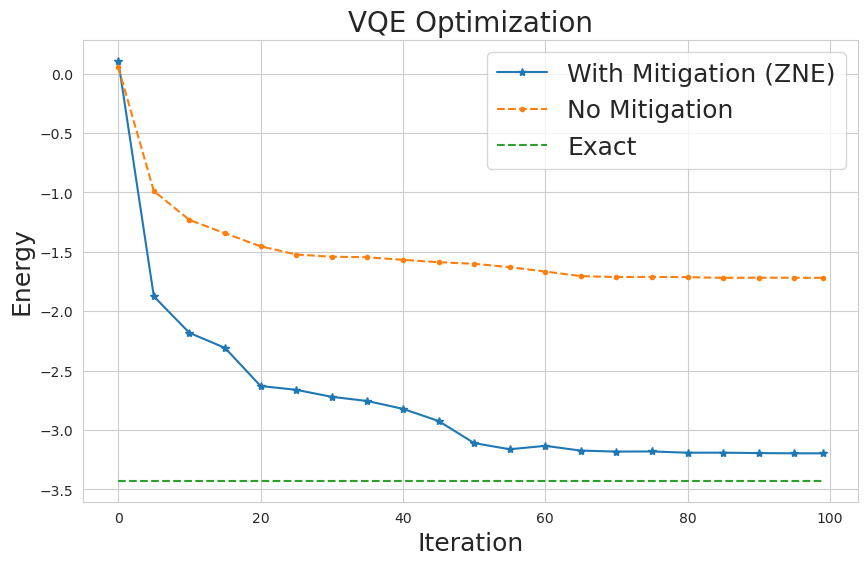

In [13]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
losses_base = log_base.cost_history
losses_zne = log_zne.cost_history
max_iter = max(losses_base.keys())
plt.plot(losses_zne.keys(), losses_zne.values(), '*-',label='With Mitigation (ZNE)')
plt.plot(losses_base.keys(), losses_base.values(), ".--",label='No Mitigation')
plt.plot([0, max_iter], [energy_exact] * 2, "--", label="Exact")
plt.legend(prop={'size':18})
plt.xlabel('Iteration',fontsize=18)
plt.ylabel('Energy',fontsize=18)
plt.title('VQE Optimization',fontsize=20)